## Objectives

- Satisfy business requirement #1:
  - The client requires a visual analysis that differentiates healthy cherry leaves from those affected by powdery mildew.

## Inputs

Images are sourced from folders for training, validation, and testing within the dataset structure:
```bash
. 
├── inputs 
│   └──cherry-leaves                                    
│       ├── test
│       │   ├── healthy
│       │   └── powdery_mildew                   
│       ├── train
│       │   ├── healthy
│       │   └── powdery_mildew          
│       └── validation
│           ├── healthy
│           └── powdery_mildew                 
└── ...
```

## Outputs

- Compute the average image size in the training set. Consistent image dimensions are essential for model training and influence CNN architecture.
- Save image dimension data as a pickle file.
- Visualize and save the mean and variance of images for each class.
- Compare healthy vs. diseased leaf images.
- Generate code and visuals to support Business Requirement #1 and provide material for a dashboard montage.

## Comments | Insights | Conclusions

These steps help us understand and organize the data for CNN input, aligning with the client’s visualization requirements (Business Requirement #1).

## Import Necessary Libraries

In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style('white')
from matplotlib.image import imread

## Set Working Directory

In [55]:
cwd = os.getcwd()

In [56]:
os.chdir('/workspaces/CI_PP5')
print("New working directory set.")

New working directory set.


In [57]:
work_dir = os.getcwd()
work_dir

'/workspaces/CI_PP5'

## Define Input Directories

Define paths for training, validation, and test datasets.

In [58]:
my_data_dir = 'inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Define Output Directory

In [59]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('An older version exists; consider creating a new version.')
else:
    os.makedirs(name=file_path)

An older version exists; consider creating a new version.


## Compute Average Image Size from Train Set

Calculating the average dimensions for images in the training set ensures uniform input size for the CNN model.

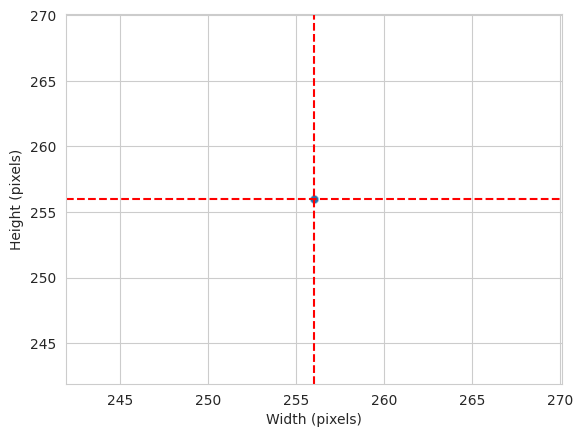

Average Width: 256 
Average Height: 256


In [60]:
dim1, dim2 = [], []
for label in os.listdir(train_path):
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, _ = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim2_mean, color='r', linestyle='--')
axes.axhline(y=dim1_mean, color='r', linestyle='--')
plt.show()
print(f"Average Width: {dim2_mean} \nAverage Height: {dim1_mean}")

### Image Size for CNN Training
Using the average dimensions calculated to ensure consistent image input size for model training.

In [61]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

### Save Image Dimension Data

In [62]:
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

## Mean and Variability of Images per Label
Calculates the mean and standard deviation images for each class (healthy and powdery_mildew).

In [63]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    """
    Load a subset of images from each label folder, resize them, and return as arrays.
    Parameters:
        - my_data_dir: Root path to dataset
        - new_size: Target size for images (height, width)
        - n_images_per_label: Max images to load per label
    Returns:
        - X: Array of images
        - y: Corresponding labels
    """

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                img_resized = image.img_to_array(img) / 255 if image.img_to_array(img).max() > 1 else image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

### Load and Display Image Shapes and Labels

In [ ]:
X, y = load_image_as_array(my_data_dir=train_path, new_size=image_shape, n_images_per_label=30)
print(X.shape, y.shape)

### Plot Mean and Variability per Label

In [64]:
def plot_mean_variability_per_labels(X, y, figsize=(8, 5), save_image=False):
    """
    Display mean and standard deviation of images for each label.
    """
    for label_to_display in np.unique(y):
        sns.set_style("white")

        boolean_mask = np.any(y.reshape(-1, 1, 1) == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()

==== Label healthy ====
==== Label powdery_mildew ====


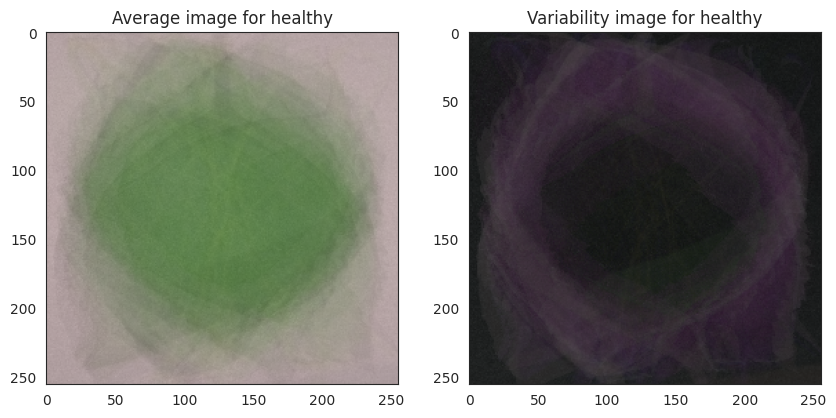

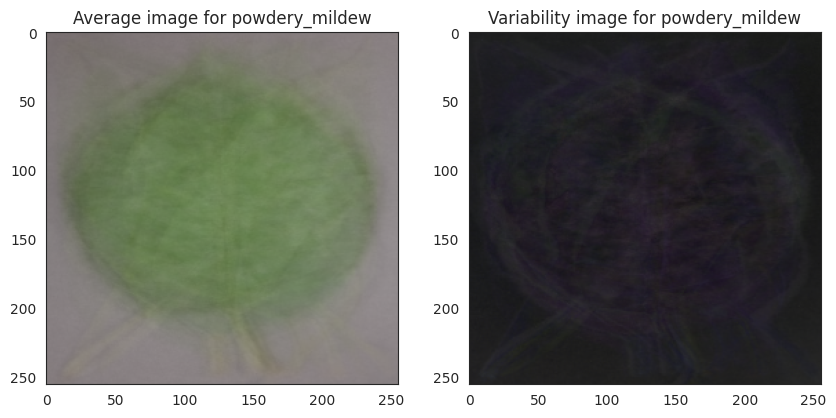

In [65]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(10, 5), save_image=True)

## Difference Between Average Healthy and Infected Cherry Leaves

In [73]:
def subset_image_label(X, y, label_to_display):
    """
    Extract subset of images for a given label.
    Parameters:
        - X: Image array
        - y: Labels array
        - label_to_display: Label for which subset is extracted
    Returns:
        - Array of images with matching label
    """
    boolean_mask = np.any(y.reshape(-1, 1, 1) == label_to_display, axis=1).reshape(-1)
    return X[boolean_mask]


def diff_avg_image_labels(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Calculate and plot the difference between the average images of two labels.
    """
    sns.set_style("white")

    if label_1 not in np.unique(y) or label_2 not in np.unique(y):
        print(f"Labels {label_1} or {label_2} not found in dataset")
        return

    avg_label1 = np.mean(subset_image_label(X, y, label_1), axis=0)
    avg_label2 = np.mean(subset_image_label(X, y, label_2), axis=0)
    difference = avg_label1 - avg_label2

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes[0].imshow(avg_label1, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(avg_label2, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference, cmap='gray')
    axes[2].set_title(f'Difference: {label_1} vs. {label_2}')

    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


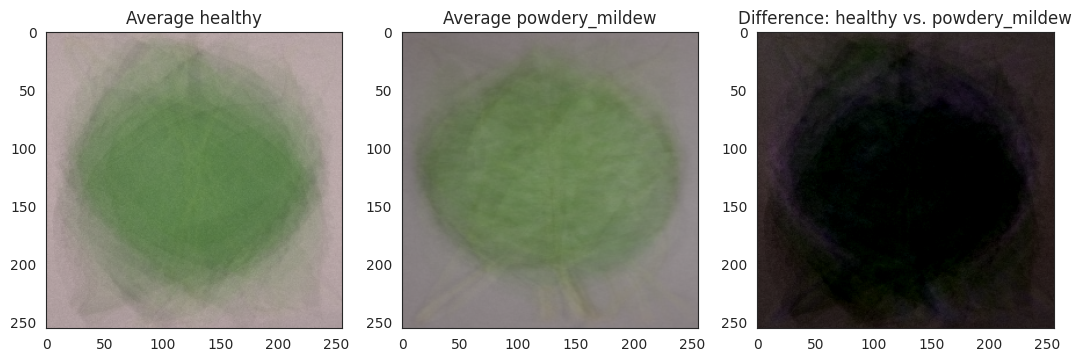

In [67]:
diff_avg_image_labels(X=X, y=y, label_1='healthy', label_2='powdery_mildew', figsize=(13, 5), save_image=True)

## Image Montage for Dataset Visualization

In [74]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    Generate a montage of images for a specified label.
    Parameters:
        - dir_path: Path to dataset
        - label_to_display: Class label for montage
        - nrows: Number of montage rows
        - ncols: Number of montage columns
    """

    if label_to_display not in os.listdir(dir_path):
        print(f"Label {label_to_display} not found. Available: {os.listdir(dir_path)}")
        return

    images_list = os.listdir(f'{dir_path}/{label_to_display}')
    if nrows * ncols > len(images_list):
        print(f"Montage size exceeds available images. Available: {len(images_list)}")
        return

    selected_images = random.sample(images_list, nrows * ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    plot_idx = list(itertools.product(range(nrows), range(ncols)))

    for idx, img_name in enumerate(selected_images):
        img = imread(f'{dir_path}/{label_to_display}/{img_name}')
        img_shape = img.shape
        row, col = plot_idx[idx]
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{img_shape[1]}px x {img_shape[0]}px")
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

### Generate Montage for All Labels

Montage for label: healthy


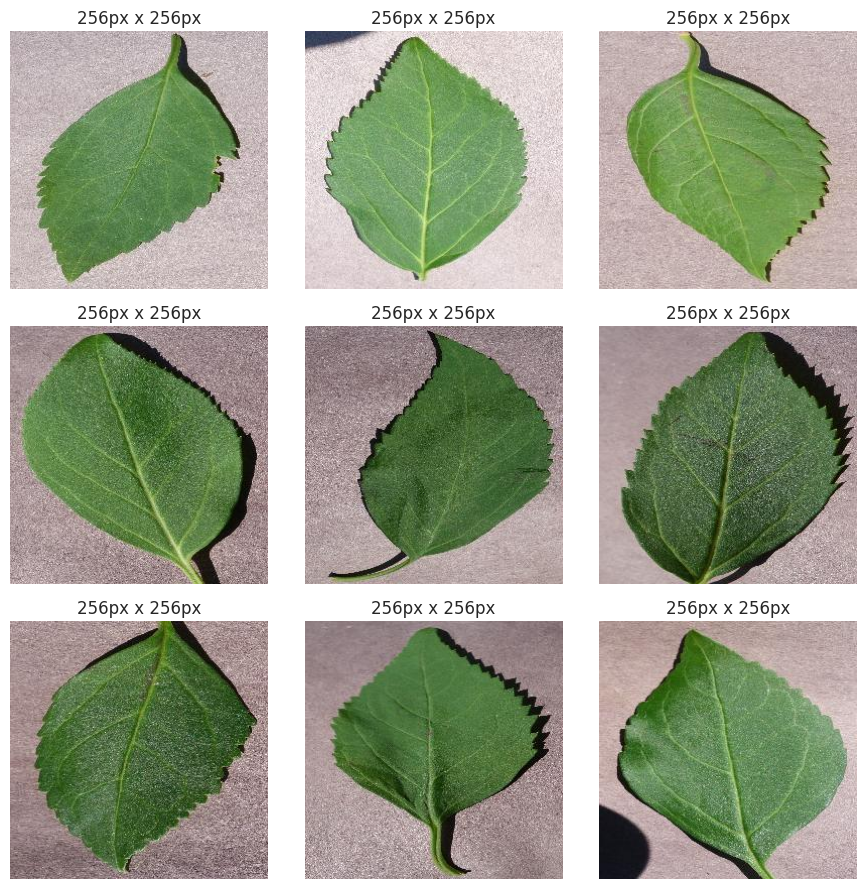



Montage for label: powdery_mildew


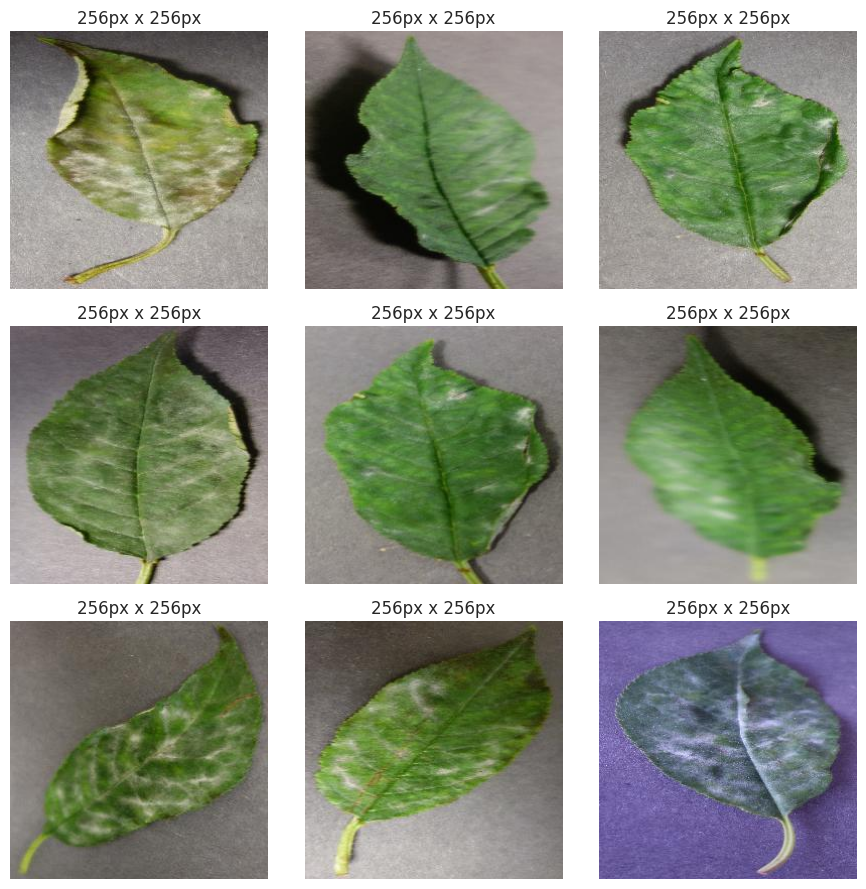



Montage for label: healthy


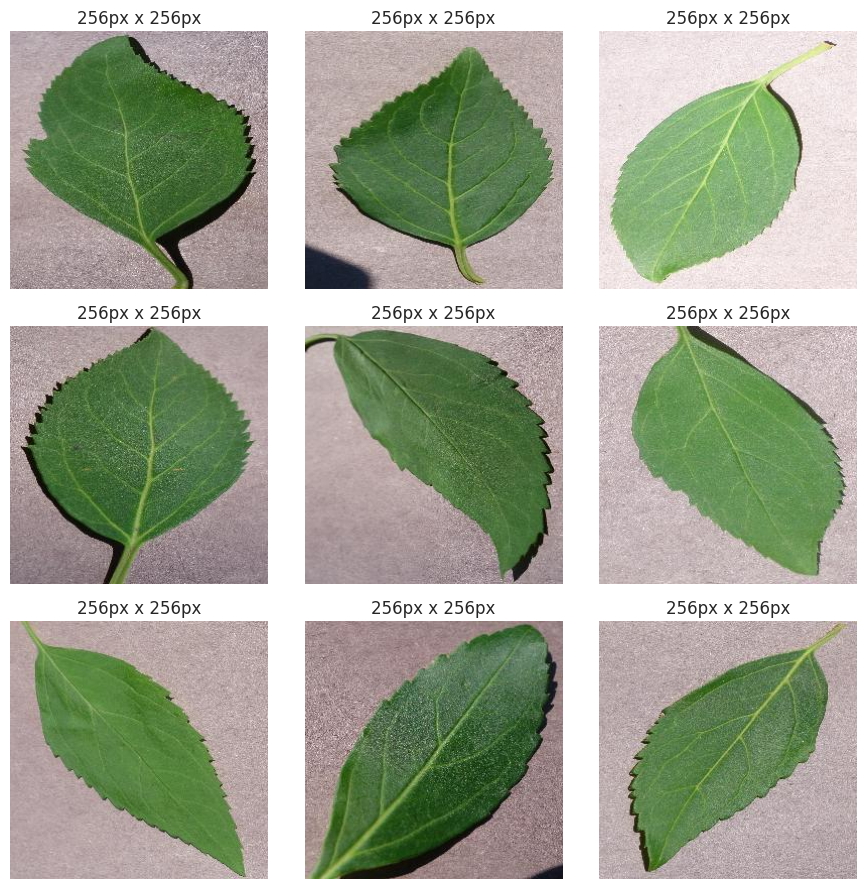



Montage for label: powdery_mildew


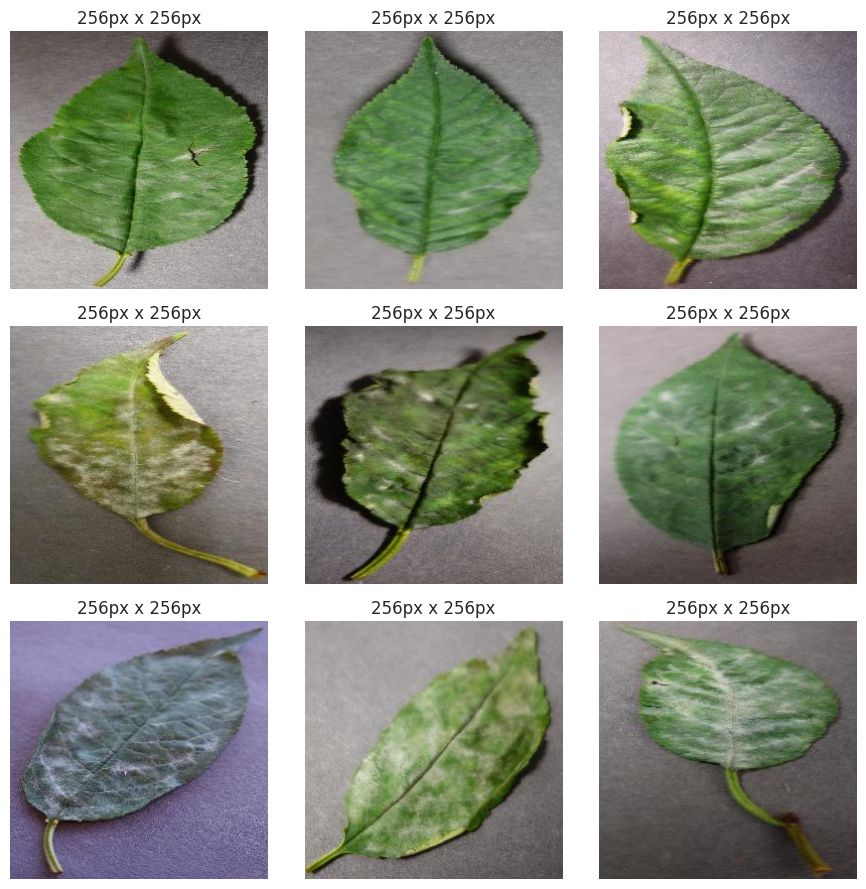

In [76]:
labels = os.listdir(train_path)
for label in labels:
    print(f'Montage for label: {label}')
    image_montage(dir_path=val_path, label_to_display=label, nrows=3, ncols=3, figsize=(9, 9))
    print("\n")


for label in labels:
    print(f'Montage for label: {label}')
    image_montage(dir_path=val_path, label_to_display=label, nrows=3, ncols=3, figsize=(9, 9))
    print("\n")